<a href="https://colab.research.google.com/github/ritwiks9635/New_Project_Ideas/blob/main/Siamese_Network_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Siamese Network using Pytorch**

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

#**Download Full Dataset**
Market-1501 dataset : https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 26.19 MiB/s, done.


In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [5]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [6]:
data = pd.read_csv(CSV_FILE)
data.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [7]:
row = data.iloc[55]

A_img = io.imread(DATA_DIR + row["Anchor"])
N_img = io.imread(DATA_DIR + row["Negative"])
P_img = io.imread(DATA_DIR + row["Positive"])

Text(0.5, 1.0, 'Positive')

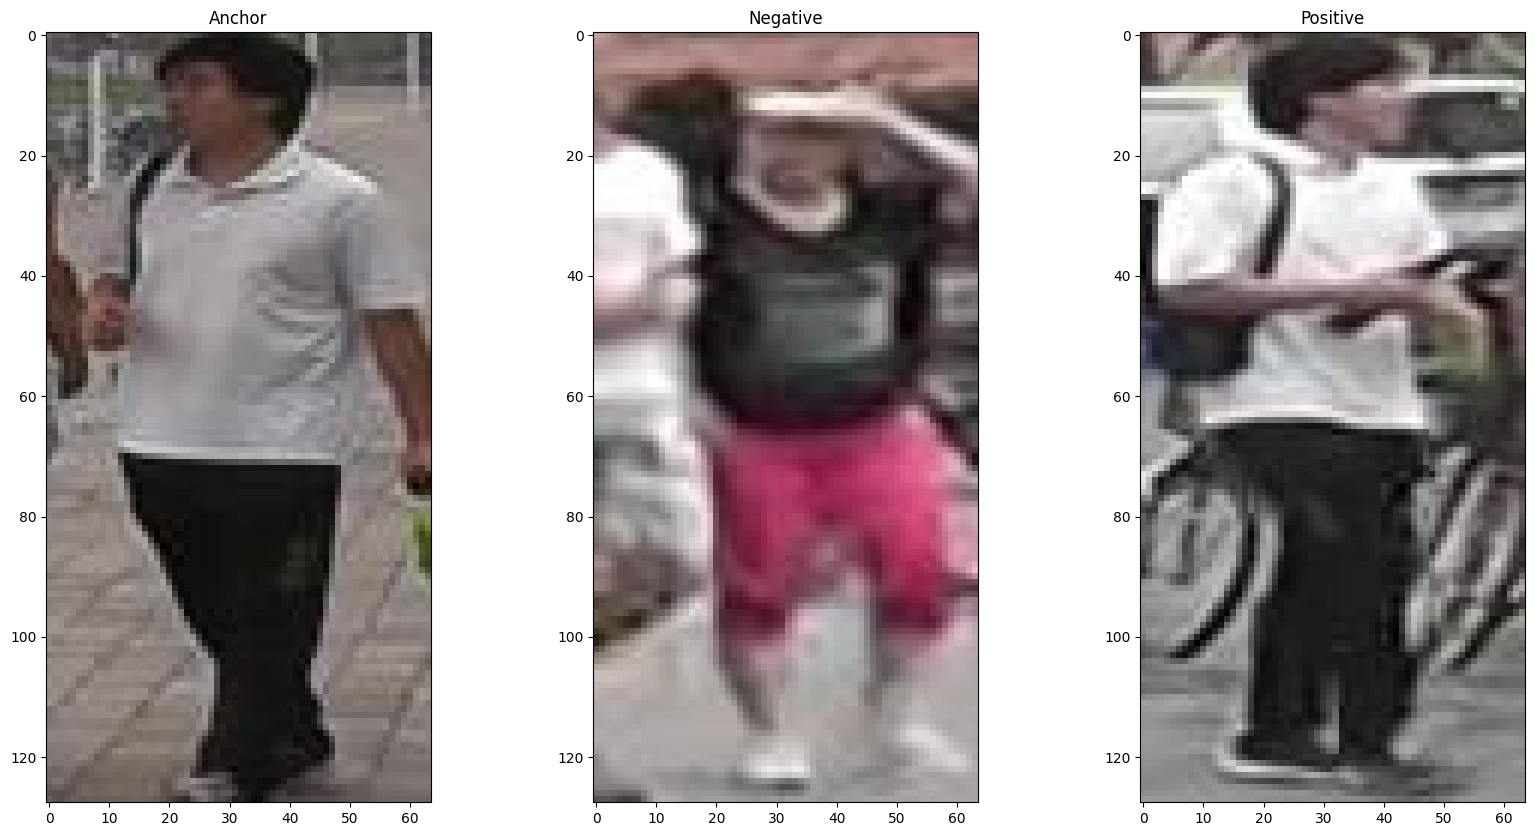

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))

ax1.imshow(A_img)
ax1.set_title("Anchor")

ax2.imshow(N_img)
ax2.set_title("Negative")

ax3.imshow(P_img)
ax3.set_title("Positive")

In [9]:
train_ds, valid_ds = train_test_split(data, test_size=0.2, random_state = 42)
print(train_ds.shape)
print(valid_ds.shape)

(3200, 3)
(800, 3)


#**Create APN Dataset**

In [10]:
class APN_Dataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]

        A_img = io.imread(DATA_DIR + row["Anchor"])
        P_img = io.imread(DATA_DIR + row["Positive"])
        N_img = io.imread(DATA_DIR + row["Negative"])

        A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
        P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
        N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

        return A_img, P_img, N_img

In [11]:
trainset = APN_Dataset(train_ds)
validset = APN_Dataset(valid_ds)

print("size of trainset ::", len(trainset))
print("size of validset ::", len(validset))

size of trainset :: 3200
size of validset :: 800


Text(0.5, 1.0, 'Positive')

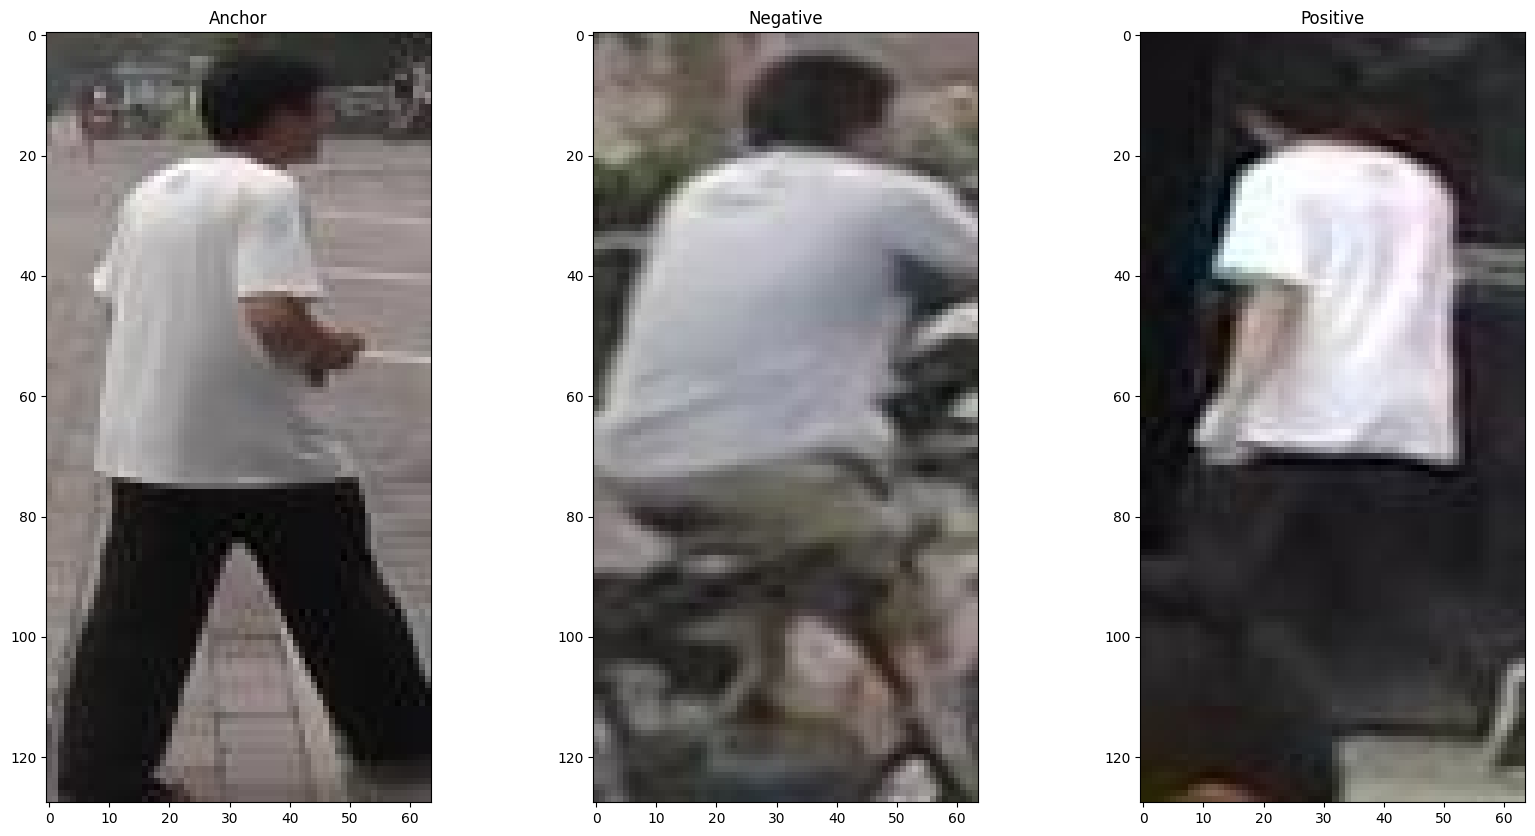

In [12]:
A, P, N = trainset[9]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))

ax1.imshow(A.numpy().transpose(1, 2, 0), cmap = "gray")
ax1.set_title("Anchor")

ax2.imshow(N.numpy().transpose(1, 2, 0), cmap = "gray")
ax2.set_title("Negative")

ax3.imshow(P.numpy().transpose(1, 2, 0), cmap = "gray")
ax3.set_title("Positive")

In [13]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

print("No of batches trainloader ::", len(trainloader))
print("No of batches validloader ::", len(validloader))

No of batches trainloader :: 100
No of batches validloader :: 25


In [14]:
for A, P, N in trainloader:
    print("One inage batch size ::", A.shape)
    break

One inage batch size :: torch.Size([32, 3, 128, 64])


In [15]:
class APN_Model(nn.Module):
  def __init__(self, emb_size=512) -> None:
      super(APN_Model, self).__init__()

      self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
      self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [16]:
model = APN_Model()
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

#**Create Train and Eval function**

In [17]:
def train_fn(model: APN_Model, dataloader: DataLoader, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [18]:
def valid_fn(model: APN_Model, dataloader: DataLoader, criterion):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [19]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

#**Create Training Loop**

In [20]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = valid_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print('SAVED_WEIGHTS success')

  print(f'EPOCH: {i+1} \t trainloss: {train_loss} \t validloss: {valid_loss}')

100%|██████████| 25/25 [00:02<00:00, 10.78it/s]


SAVED_WEIGHTS success
EPOCH: 1 	 trainloss: 0.5629547245800495 	 validloss: 0.46971559166908267


100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


SAVED_WEIGHTS success
EPOCH: 2 	 trainloss: 0.3198812706768513 	 validloss: 0.24190268754959107


100%|██████████| 25/25 [00:02<00:00, 10.93it/s]


SAVED_WEIGHTS success
EPOCH: 3 	 trainloss: 0.123577518761158 	 validloss: 0.2040935355424881


100%|██████████| 25/25 [00:02<00:00,  8.88it/s]


SAVED_WEIGHTS success
EPOCH: 4 	 trainloss: 0.08385953478515148 	 validloss: 0.19164977908134462


100%|██████████| 25/25 [00:02<00:00, 10.98it/s]


EPOCH: 5 	 trainloss: 0.0716800244897604 	 validloss: 0.25259633362293243


100%|██████████| 25/25 [00:02<00:00, 10.89it/s]


EPOCH: 6 	 trainloss: 0.07380911469459533 	 validloss: 0.2293759298324585


100%|██████████| 25/25 [00:02<00:00,  9.18it/s]


EPOCH: 7 	 trainloss: 0.08248388916254043 	 validloss: 0.2731536191701889


100%|██████████| 25/25 [00:02<00:00, 10.74it/s]


SAVED_WEIGHTS success
EPOCH: 8 	 trainloss: 0.06462170235812664 	 validloss: 0.18896966099739074


100%|██████████| 25/25 [00:02<00:00,  9.59it/s]


SAVED_WEIGHTS success
EPOCH: 9 	 trainloss: 0.05678691774606705 	 validloss: 0.15852253317832946


100%|██████████| 25/25 [00:02<00:00, 10.65it/s]


EPOCH: 10 	 trainloss: 0.03740373224020004 	 validloss: 0.20449014961719514


100%|██████████| 25/25 [00:02<00:00, 11.08it/s]


EPOCH: 11 	 trainloss: 0.04796002805233002 	 validloss: 0.17709968209266663


100%|██████████| 25/25 [00:03<00:00,  8.05it/s]


EPOCH: 12 	 trainloss: 0.048709512650966645 	 validloss: 0.21331621646881105


100%|██████████| 25/25 [00:02<00:00, 10.55it/s]


EPOCH: 13 	 trainloss: 0.03605246812105179 	 validloss: 0.17637634336948393


100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


EPOCH: 14 	 trainloss: 0.03183135703206062 	 validloss: 0.18789074182510376


100%|██████████| 25/25 [00:02<00:00, 10.90it/s]

EPOCH: 15 	 trainloss: 0.025978604704141615 	 validloss: 0.1751328629255295


#**Get Anchor Embeddings**

In [21]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0)) # add batch -> (batch, c, h, w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis=1)

  return df_enc

In [22]:
model.load_state_dict(torch.load('/content/best_model.pt'))
data_enc = get_encoding_csv(model, data['Anchor'])

100%|██████████| 4000/4000 [00:46<00:00, 85.35it/s]


In [23]:
data_enc.to_csv('/content/database.csv', index=False)
data_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.697904,-1.535335,0.338757,-0.666475,0.069719,0.019348,-0.544903,0.090482,-0.302251,...,0.087387,0.723176,-0.425305,-0.288691,-0.254721,0.091803,-0.155306,-0.559889,-0.103033,-0.409136
1,1420_c3s3_061978_03.jpg,0.096989,-1.207293,0.631425,-1.037740,-0.436926,-0.303988,-0.160704,0.259506,-0.325863,...,0.232868,0.987029,-0.378823,-0.016135,0.471765,-0.159591,0.374359,-0.246775,-0.446369,-0.285396
2,1420_c5s3_062565_05.jpg,-0.074414,-1.056267,0.011037,-0.668110,-0.109825,0.038914,-0.134586,-0.159133,-0.386377,...,0.811803,0.957597,-0.441069,0.077457,0.003974,-0.090525,-0.655618,-0.767242,0.168567,-0.025857
3,1420_c6s3_085592_04.jpg,0.027807,-1.430795,0.207183,-0.659918,-0.065698,-0.111415,0.130061,-0.292212,-0.493105,...,1.101089,1.346087,-0.584239,0.371259,0.067379,-0.092586,-1.099150,-0.969764,0.428959,0.450696
4,0663_c5s3_085987_03.jpg,0.987612,0.009624,0.302208,-0.376658,-0.359138,0.195528,-0.628661,-0.304964,-0.424275,...,-0.041217,-0.335668,-0.560208,-0.662212,-0.571131,1.159400,-0.648972,-0.194923,0.346150,0.718647


#**Inference**

In [24]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
  return dist

In [25]:
idx = 8
img_name = data_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [26]:
anc_enc_arr = data_enc.iloc[:, 1:].to_numpy()
anc_img_names = data_enc['Anchor']

In [27]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1 :])
  distance = np.append(distance, dist)

In [28]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:724: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


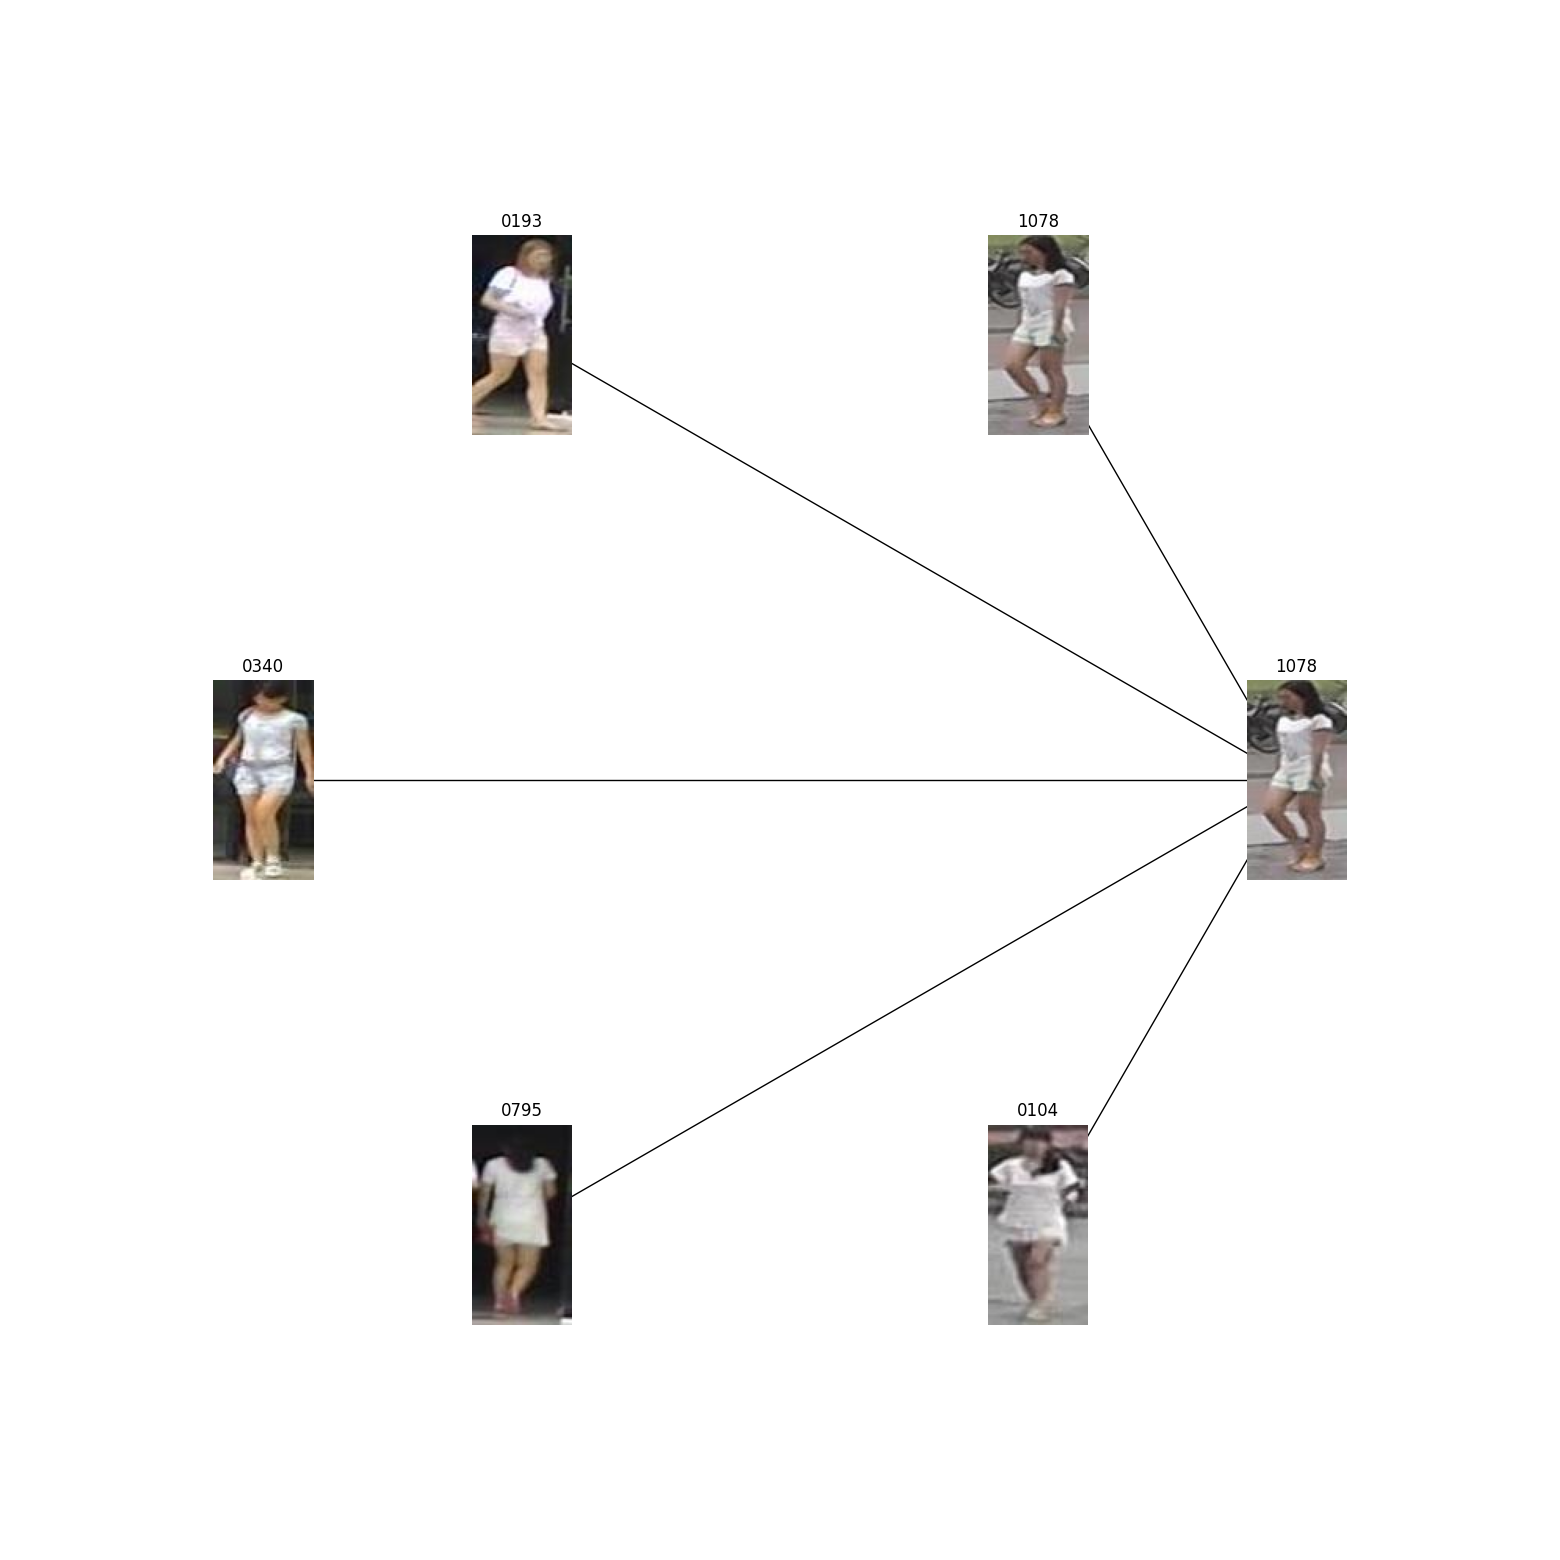

In [31]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);